# Predicting Median Housing Price per District

**Summary:**

This notebooks is based on O-Reilly's "Hands-on machine learning" textbook. The purpose of this problem is making a complete project to predict the median housing price of a district in California, from obtaining data to model evaluation.

The datasource has the main issue that it is capped on the median_house_value label that is our dependent variable. This is an issue since the machine learning algorithms might never go beyond that limit. In real world applications I could check with the client team and see if this is a problem or not. If they need precise predictions even beyond $500.000 then there would be 2 options: Collect proper labels for the districts whose labels were capped; remove those districts from the training set (and later from the test set). On this example we will remove the capped labels.

The selected models are just linear regression, desicion tree, random forest and SVM. Just to show different ways to proceed some models are trained with cross-validation, some with grid-search and some with Random Search. The selection of models is used mainly to display the selecting and training process and different metrics to select a model.

The random forest Random Search is used as the selected model with a rmse of 44082 and confidence interval of \[42111, 45969]

The purpose of this notebook is to show an example of a full model development, as explained on the final conclusion this model is not suggested unless it is better than previous methods of estimating median housing costs or it reduces the cost of estimating the model considerably.


Important Steps:
- EDA: we analyze data and get a preliminary understanding, tools used:
    - Data Description
    - Graphs
    - Feature Extraction
    - Create Stratified Train Test Set
- Data Preparation:
    - Create Custom Transformers to Add new Attributes
    - Create Pipeline for Numerical Attributes
        - SimpleImputer: fill NA's
        - StandardScaler: scale features through standarization
    - Create Complete Transformation Pipeline:
        - Use numerical pipeline
        - Use categorical pipeline (With One-Hot Encoder)
- Selecting and Training Models:
    - For Machine Learning Algorithms are used: Linear Regression, SVM, Desicion Tree and Random Forest
    - Other Elements:
        - Cross Validation
        - Grid Search CV
        - Random Search CV
        - Determining Feature Importance
- Model Evaluation:
    - We evaluate the model on the test set
    - RMSE accuracy
    - 95\% confidence interval

## Setup:

In [98]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## Part 1: Obtaining the Data

This section obtains is code just to fetch the data regarding california housing prices.

In [99]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()

## Part 2: Initial Data Exploration

In this section we will study the data at hand with an initial analysis and adequately prepare the data to see if we could accurately estimate median housing prices per district.

In [100]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [101]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [102]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

We see there are a total of 9 atributes on the table plus our dependent variable (median_house_value), all attributes are floats with exception of ocean_proximity that is a categorical variable. We see that total_bedrooms has 207 missing values.

The ocean_proximity has 5 categories related to proximity in the ocean with a loc count of values for properties on Islands.

In [103]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


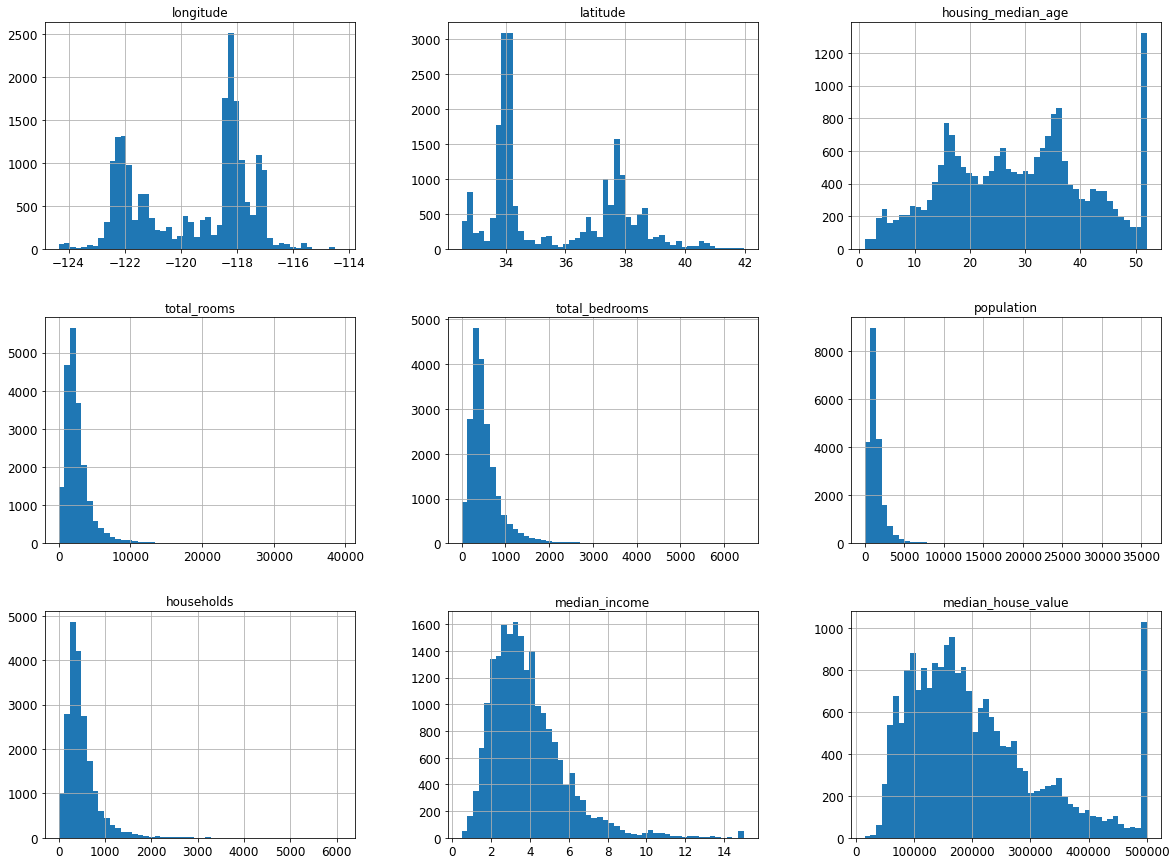

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

**Observations:**

1. housing_median_age and median_house_value seem to be capped at 52 and 500.001 respectively. The biggest concern is the median_house_value since it is our dependent variable.

2. median_income is not expressed in US dollars. Information on the dataset tells us it has been scaled and capped between .5 and 15. The numbers represent tens of thousands of dollars. Ex. 3 = 30.000

3. Histograms seem to be tail heavy

4. Attributes are on different scales

We will proceed to remove capped values and explore the model from there on the EDA.

On the textbook it explains the importance of median housing prices, that is why we will do stratified sampling based on the income category.

<AxesSubplot:>

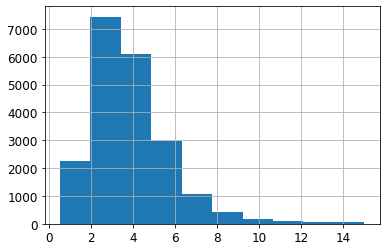

In [105]:
housing["median_income"].hist()

<AxesSubplot:>

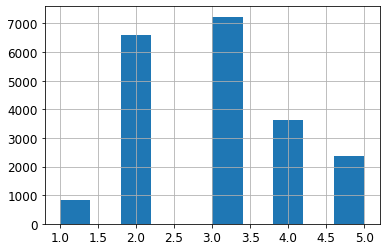

In [106]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins= [0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels= [1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [107]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    train = housing.loc[train_index]
    test = housing.loc[test_index]

# We check if Strata was appropiatelly separated
previous_dist = housing["income_cat"].value_counts()/len(housing)
train_dist = train["income_cat"].value_counts()/len(train)
test_dist = test["income_cat"].value_counts()/len(test)
strata_df = pd.concat([previous_dist, train_dist, test_dist], 
                      axis=1, keys=['housing', 'train', 'test'])

for set_ in (train, test):
    set_.drop("income_cat", axis=1, inplace=True)

strata_df

,housing,train,test
3,0.350581,0.350594,0.350533
2,0.318847,0.318859,0.318798
4,0.176308,0.176296,0.176357
5,0.114438,0.114402,0.114583
1,0.039826,0.039850,0.039729


We just separated the train test set strattified by 5 income categories and dropped the created income category attribute. The df shows that each stratum has a balanced number of instances.

## Part 3: EDA


In [108]:
housing_1 = train.copy()
length = len(housing_1)

housing = housing_1[(housing_1["median_house_value"] < 500001) & 
                  (housing_1["housing_median_age"] < 52) & 
                  (housing_1["median_income"] < 15.000100)].copy()

print("Removed Values:", length-len(housing))
print("Train Size:", len(housing))

Removed Values: 1675
Train Size: 14837


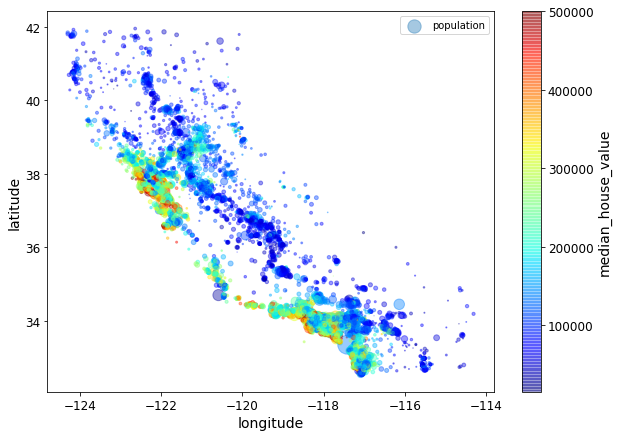

In [109]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

We observe a high density on the Bay Area and central valley. Prices seem to be very related to the location ex. close to the ocean and the population density. We will view correlation between atrributes and house value. Clearly the highest correlation is related to the median_income.

In [110]:
housing.corr().median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.658226
total_rooms           0.153637
households            0.101600
total_bedrooms        0.080232
population            0.021401
housing_median_age    0.021380
longitude            -0.020206
latitude             -0.173417
Name: median_house_value, dtype: float64

We know see the difference between a scatter plot since we have removed the capped values.

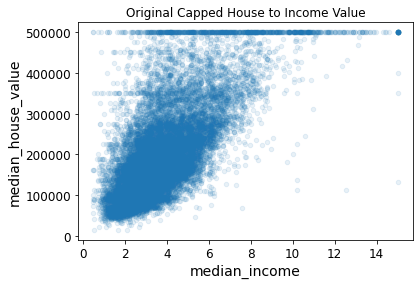

In [111]:
%matplotlib inline
housing_1.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.title("Original Capped House to Income Value")
plt.show()

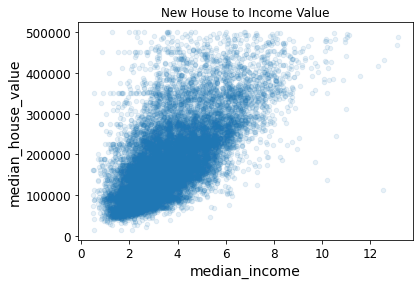

In [112]:
%matplotlib inline
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.title("New House to Income Value")
plt.show()

We confirm the high correlation with an upward trend income to value. The 500.001 price cap can clearly be seen on the graph. There seems to be other 2 straigh lines at 450.000 and 350.000.

The total amount of rooms in a district might not be as relevant as rooms per household, so we will create this attribute and study it's correlation. We will also see the number of bedrooms per room and the population per household.

In [113]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
housing.corr().median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.658226
total_rooms                 0.153637
rooms_per_household         0.107621
households                  0.101600
total_bedrooms              0.080232
population                  0.021401
housing_median_age          0.021380
population_per_household   -0.018749
longitude                  -0.020206
latitude                   -0.173417
bedrooms_per_room          -0.231078
Name: median_house_value, dtype: float64

Bedrooms per room has a much higher correlation than total number of rooms or total number of bedrooms. Rooms per household also seems to have a higher correlation than total number of rooms and total number of households.

Now that we have a better idea of our data we could start preparing for our model.

## Part 4: Data Preparation

We will revert to a clean stratiffied training set and prepare the predictors and the labels. We will create a transformation pipeline to handle the data.

In [133]:
housing = train.drop("median_house_value", axis=1)
housing.head()


housing = train.copy()
housing = housing[(housing["median_house_value"] < 500001) & 
                  (housing["housing_median_age"] < 52) & 
                  (housing["median_income"] < 15.000100)].copy()

housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


### Custom Transformer: Combined Attributes

Since we noticed in our EDA that some combined attributes had higher correlations we will create a transformer that will combine these attributes. We add the add_bedrooms_per_room hyperparameter to find out weather this attribute helps the Machine Learning algorithm or not.

In [134]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [135]:
# This block of code is only to show our transformer in action

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra = attr_adder.transform(housing.values)

housing_extra = pd.DataFrame(
    housing_extra,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847


### Creating a Pipeline for Numerical Attributes

For our numeric values we create a pypeline that follows three steps:
1. SimpleImputer: we fill the missing total_bedroom values with their median
2. We use our combined attributes transformer
3. StandardScaler: we scale our features through standarization.

In [136]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

### Creating a complete Transformation Pipeline

Our complete Pipeline has two parts:
1. Numerical Pipeline, the steps previously programmed
2. OneHotEncoder: transformation applied to our categorical attribute

In [137]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder

# We separate the numerical and categorical attributes to work on our pipeline
num_attribs = housing.columns.to_list()[:-1]
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared[0]) # We print the first row

[-1.21504405  0.78708795  0.96688658 -0.49918763 -0.46121007 -0.65977027
 -0.43673345 -0.62994715 -0.31408184 -0.08631525  0.15000095  1.
  0.          0.          0.          0.        ]


## Part 5: Select and Train a Model

We now train our model with different machine learning algorithms and test their performance.

In [149]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

### Linear Regression with Cross Validation

We observe that this model has a RMSE of 58.784. This is a large error considering that houses usually range in a 150.000 to 300.000 dollar range.

In [150]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [57159.94462979 58272.24256295 57947.36328605 63783.57762489
 59229.37217153 59613.0702014  55934.13890431 58019.22643593
 60473.58453863 57411.02609835]
Mean:  58784.35464538432
Standard deviation:  2071.8890309908384


### DecisionTree with Cross Validation

Our model has performed even worse than the linear regression.

In [151]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)


scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores:  [64063.19177524 62544.62625128 63690.62162531 63858.09233663
 62606.0575077  64899.59347657 61298.40944103 62245.92792158
 63146.5975718  63885.96926173]
Mean:  63223.90871688811
Standard deviation:  1004.1805180646104


### SVM with Cross Validation

SVM has a far worse performance and is also computationally heavy, it is not recommended to use this model.

In [152]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)
display_scores(svm_rmse_scores)

Scores:  [85624.67272724 92953.07188828 88911.04144237 92022.55275915
 92947.80645401 93146.42195267 90998.67312007 92744.34781336
 93077.17450618 90980.45361163]
Mean:  91340.62162749586
Standard deviation:  2296.0102000188554


### Random Forest

Random Forest seems to perform betther than all models, here we will display different ways that it is tested, RandomizedSearchCV is the prefered way to measure this since you could have more control over the computing budget you want to allocate to hyperparameter search in comparison with grid search.

With Cross Validation:


In [142]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)
display_scores(svm_rmse_scores)

Scores:  [45087.52558356 43245.42908526 44995.85421525 46741.39900013
 44766.60545641 45530.5721248  44342.22423666 43585.36469923
 46500.97719511 44429.821042  ]
Mean:  44922.57726384241
Standard deviation:  1068.0169967326292


Grid Search:

In [143]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features':[2 , 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

print("Best Parameters: ", grid_search.best_params_)
print("Best Estimator: ", grid_search.best_estimator_)
print("Best Score: ", np.sqrt(-grid_search.best_score_))

Best Parameters:  {'max_features': 6, 'n_estimators': 30}
Best Estimator:  RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)
Best Score:  44586.63958637743


Random Search:

In [144]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

print("Best Parameters: ", rnd_search.best_params_)
print("Best Estimator: ", rnd_search.best_estimator_)
print("Best Score: ", np.sqrt(-rnd_search.best_score_))

Best Parameters:  {'max_features': 7, 'n_estimators': 180}
Best Estimator:  RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)
Best Score:  44310.829606381674


In [145]:
feature_importances = rnd_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)[:10]

[(0.32378300221920786, 'median_income'),
 (0.16717325381863038, 'INLAND'),
 (0.1021740678129795, 'pop_per_hhold'),
 (0.07888403302806736, 'longitude'),
 (0.07181160602363465, 'bedrooms_per_room'),
 (0.07113259990182806, 'latitude'),
 (0.0433586453231094, 'rooms_per_hhold'),
 (0.039465160464484415, 'housing_median_age'),
 (0.019129181404693853, 'total_rooms'),
 (0.01891926875173834, '<1H OCEAN')]

## Part 6: Model Evaluation:

We will removed the capped labels as we did with our train set since we defined to not consider predictions above that range.

In [159]:
final_model = grid_search.best_estimator_

X_test = test.copy()
X_test = X_test[(X_test["median_house_value"] < 500001) & 
                  (X_test["housing_median_age"] < 52) & 
                  (X_test["median_income"] < 15.000100)].copy()

y_test = X_test["median_house_value"].copy()
X_test = X_test.drop("median_house_value", axis=1)

X_test_prepared = full_pipeline.transform(X_test)

There is still a large error of 44082, if this where better than previous methods of estimating median housing costs it might be worth considering it's implementation. Also it might be considered if it performs slightly worse but the costs of obtaining this estimate far surpases the previous methods cost.

In [161]:
from sklearn.metrics import mean_squared_error

final_predictions = final_model.predict(X_test_prepared)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

44082.6268755209

We also view the 95% confidence interval for the generalization error.

In [158]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([42111.31880256, 45969.47697334])

We observe that there are quite a few faults with this model, starting with the capped data that affects the range for which the model could be used or the accuracy of the data. 

The RMSE shows quite a high value meaning the model will probably not be used.

Only a few machine learning algorithms where used, we could add more models and create a pipeline that would help find the better model, nevertheless since the data itself has an issue it might not be worth continuing unless this is solved first.